# Drawdown caused by groundwater extraction
*R.A. Collenteur & M. Bakker*


In [1]:
import pandas as pd
import pastas as ps
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
head = pd.read_csv("../data/head_wellex.csv", index_col="Date", parse_dates=True)
head = pd.read_csv("../data/head_wellex.csv", index_col="Date", parse_dates=True)
head = pd.read_csv("../data/head_wellex.csv", index_col="Date", parse_dates=True)
head = pd.read_csv("../data/head_wellex.csv", index_col="Date", parse_dates=True)

DatetimeIndex(['1995-01-14', '1995-01-28', '1995-02-15', '1995-03-01',
               '1995-03-15', '1995-03-28', '1995-04-14', '1995-04-28',
               '1995-05-16', '1995-05-30',
               ...
               '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06',
               '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10',
               '2018-01-11', '2018-01-12'],
              dtype='datetime64[ns]', name='Date', length=3869, freq=None)

NameError: name 'mlw' is not defined

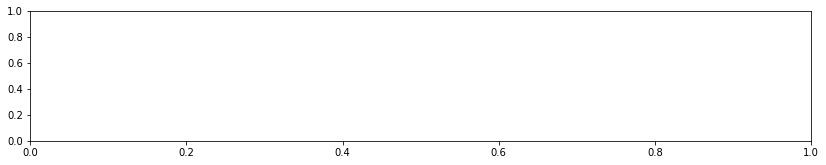

In [3]:
plt.figure(figsize=(14, 9))
ax1 = plt.axes([0.125, 0.68, 0.775, 0.2])
xticks = pd.date_range(start=pd.Timestamp('1995-01-01'), end=pd.Timestamp('2015-01-01'), freq='5AS-Jan')
mlw.oseries['1995':'2015'].plot(style='k.', label='observed', xticks=xticks, markersize=8)
plt.xlim(pd.Timestamp('1995-01-01'), pd.Timestamp('2015-01-01') )
plt.setp(ax1.get_xticklabels(), visible=False)
plt.xlabel('')
plt.ylabel('m')
ax2 = plt.axes([0.125, 0.54, 0.775, 0.1])
rainw['1995':'2015'].plot(color='C0')
#evapw['1995':'2015'].plot(color='C1')
plt.ylim(0, 0.05)
plt.xlim(pd.Timestamp('1995-01-01'), pd.Timestamp('2015-01-01') )
plt.setp(ax2.get_xticklabels(), visible=False)
plt.xlabel('')
plt.ylabel('m/d')
ax2b = plt.axes([0.125, 0.4, 0.775, 0.1])
#rainw['1995':'2015'].plot(color='C0')
evapw['1995':'2015'].plot(color='C2')
plt.ylim(0, 0.05)
plt.xlim(pd.Timestamp('1995-01-01'), pd.Timestamp('2015-01-01') )
plt.setp(ax2b.get_xticklabels(), visible=False)
plt.xlabel('')
plt.ylabel('m/d')
#plt.legend()
ax3 = plt.axes([0.125, 0.26, 0.775, 0.1])
wellq[:'2015'].plot(color='C1')
plt.xlim(pd.Timestamp('1995-01-01'), pd.Timestamp('2015-01-01') )
#plt.ylim(-2.1, -0.6)
plt.xlabel('Year')
plt.ylabel('Discharge')
#plt.legend(loc='upper left')
plt.savefig('figwellinput.eps', bbox_inches='tight')

In [4]:
head

,1995-01-14,15.74
0,1995-01-28,15.920000
1,1995-02-15,16.170000
2,1995-03-01,16.260000
3,1995-03-15,16.120000
4,1995-03-28,16.080000
5,1995-04-14,15.960000
6,1995-04-28,15.590000
7,1995-05-16,15.800000
8,1995-05-30,15.790000
9,1995-06-15,15.770000
